# Week 8
## Overview

It's the last time we meet in class for exercises! And to celebrate this mile-stone, I've put together an very nice little set of exercises. And if you're behind, don't worry. The workload is low!

  - Part A: First, we play around with sentiment analysis
  - That's it!


# Part A: Sentiment analysis

Sentiment analysis is another highly useful technique which we'll use to make sense of the Wiki
data. Further, experience shows that it might well be very useful when you get to the project stage of the class.



> **Video Lecture**: Uncle Sune talks about sentiment and his own youthful adventures.



In [1]:
# from IPython.display import YouTubeVideo
# YouTubeVideo("JuYcaYYlfrI",width=800, height=450)

In [2]:
# # There's also this one from 2010 with young Sune's research
# YouTubeVideo("hY0UCD5UiiY",width=800, height=450)

> Reading: [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) 


*Exercise*: Sentiment distribution. 
> 
> * Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1). Describe briefly how the list was generated.
> * Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).
> * Iterage over the nodes in your network, tokenize each page, and calculate sentiment every single page. Now you have sentiment as a new nodal property.
> * Calculate the average sentiment across all the pages. Also calculate the median, variance, 25th percentile, 75th percentile.
> * Remember histograms? Create a histogram of all of the artists's associated page-sentiments. (And make it a nice histogram - use your histogram making skills from Week 2). Add the mean, meadian, ect from above to your plot.
> * Who are the 10 artists with happiest and saddest pages?

<div class="alert alert-block alert-info">
As long as you get the plots right, it's OK to use LLM help here.
</div>

> **Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1). Describe briefly how the list was generated.**\
> **ANSWER:**\
> The LabMT word list was generated by collecting human evaluations of the perceived happiness of around 10,000 of the most frequently used english words. Ratings were obtained via Amazon's "Mechanical Turk", where participants scored each word on a scale on 1-9 based on how happy it felt.

> **Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).**\
> **ANSWER:**\
> See below, we write in Python.

In [76]:
import pandas as pd

df = pd.read_csv("../data/data_set_1.txt", sep='\t', header=None, names=['word', 'happiness_rank', 'happiness_average', 'happiness_standard_deviation', 'twitter_rank', 'google_rank', 'nyt_rank', 'lyrics_rank'])
df = df.iloc[3:]

# Now we replace "--" with NaN:
df = df.replace('--', pd.NA)
df.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
3,laughter,1,8.50,0.9313,3600,<NA>,<NA>,1728
4,happiness,2,8.44,0.9723,1853,2458,<NA>,1230
5,love,3,8.42,1.1082,25,317,328,23
6,happy,4,8.30,0.9949,65,1372,1313,375
7,laughed,5,8.26,1.1572,3334,3542,<NA>,2332


In [176]:
import numpy as np
from collections import Counter
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

# We gather our list of tokens, which is the word column lowercased:
tokens = df['word'].str.lower().tolist()

# We have to make a function that calculates sentiment given a list of tokens:
def sentiment_calculator(token_list, df):
    if not isinstance(token_list, list):
        # Convert sentence to a list of tokens:
        token_list = [word.lower() for word in word_tokenize(token_list)]
    else:
        # Ensure all tokens are lower case:
        token_list = [word.lower() for word in token_list]
    
    # Find all matching words with our token_list with df word list:
    matching_words = set(token_list).intersection(set(df["word"]))

    if len(matching_words) == 0:
        return {"happiness_avg_scores": [], "mean_happiness": np.nan}

    # Now calculate sentiment based on the happiness_average of the matching words:
    happiness_avg_scores = df[df["word"].isin(matching_words)]["happiness_average"].astype(float).values
    mean_score = np.nanmean(happiness_avg_scores)

    # happiness_std = df[df["word"].isin(matching_words)]["happiness_standard_deviation"].astype(float).values
    # std_score = np.nanmean(happiness_std)

    return {"happiness_avg_scores": happiness_avg_scores, "mean_happiness": round(float(mean_score), 2)}

In [189]:
test_result = sentiment_calculator("this is a very happy sentence with laughter joy and we all laughed", df)
test_result

{'happiness_avg_scores': array([8.5 , 8.3 , 8.26, 8.16, 6.38, 6.22, 6.12, 5.72, 5.24, 5.22, 5.22,
        5.18, 5.06]),
 'mean_happiness': 6.43}

> **Iterage over the nodes in your network, tokenize each page, and calculate sentiment every single page. Now you have sentiment as a new nodal property.**\
> **ANSWER:**\
> I guess we have to load our rock network...

In [190]:
# Now for the genre documents:
import os
import pickle
import re

directory = "../data/rock_performers/"

all_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".pkl")]

all_performers = [os.path.splitext(os.path.basename(f))[0] for f in all_paths]
performer_set = set(all_performers)
    
opened_files = {}

for file_path in all_paths:
    performer = os.path.splitext(os.path.basename(file_path))[0]
    
    # Load pickled page
    with open(file_path, "rb") as f:
        wikitext = pickle.load(f)

    opened_files[performer] = wikitext # Dictionary of {performer: wikitext}

##################################################################################
# We have to tokenize each page now:
from nltk.tokenize import word_tokenize

tokenized_pages = {}

for performer, wikitext in opened_files.items():
    # Tokenize the wikitext
    clean_text = re.sub(r'\{\{.*?\}\}|\[\[.*?\]\]|\<.*?\>|==.*?==', ' ', wikitext)
    tokens = [word.lower() for word in word_tokenize(clean_text)]
    tokenized_pages[performer] = tokens
##################################################################################

In [191]:
# Now calculate sentiment for each page and store as a new nodal property:
sentiment_results = {}
for performer, tokens in tokenized_pages.items():
    sentiment = sentiment_calculator(tokens, df)
    sentiment_results[performer] = sentiment["mean_happiness"]

In [ ]:
import networkx as nx

G = nx.DiGraph()

def clean_name(name):
    return re.sub(r'[\\/*?:"<>|]', "_", name).replace(" ", "_")

all_performers = [clean_name(os.path.splitext(os.path.basename(f))[0]) for f in all_paths]
performer_set = set(all_performers)

matching_links_collection = {}

for file_path in all_paths:
    performer = clean_name(os.path.splitext(os.path.basename(file_path))[0])
    
    with open(file_path, "rb") as f:
        wikitext = pickle.load(f)

    all_links = re.findall(r"\[\[(.*?)\]\]", wikitext)
    filtered_links = []

    for link in all_links:
        if any(x in link for x in ["File", "Image", "Special", "Category", "rock music"]):
            continue
        
        clean_link = clean_name(re.split(r'\|', link)[-1])
        if clean_link != performer and clean_link in performer_set:
            filtered_links.append(clean_link)
    
    matching_links_collection[performer] = filtered_links
########################

# Build the graph itself:
for performer in all_performers:
    # Build the path to the correct file for this performer
    file_path = os.path.join(directory, f"{performer}.pkl")
    
    with open(file_path, "rb") as f:
        text = pickle.load(f)
        word_count = len(text.split())  # simpler and more accurate word count

    # Add performer node with word_count attribute
    G.add_node(performer, word_count=word_count)

    # Add edges to linked performers
    for target in matching_links_collection.get(performer, []):
        G.add_edge(performer, target)
########################

# Final clean ups:
isolated = list(nx.isolates(G))

G.remove_nodes_from(isolated)

# Now add sentiment as a nodal property:
cleaned_sentiment_results = {clean_name(k): v for k, v in sentiment_results.items()}
for performer, score in cleaned_sentiment_results.items():
    if performer in G.nodes:
        G.nodes[performer]['sentiment'] = score

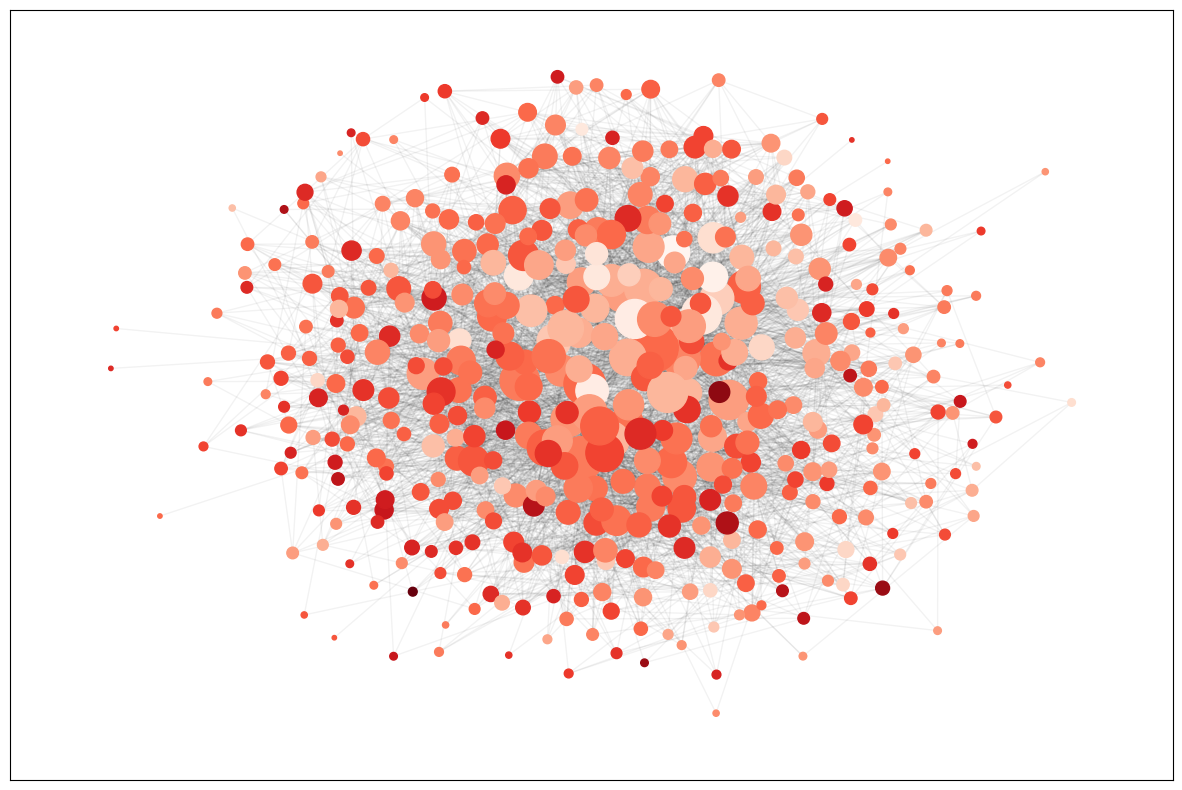

In [245]:
# Now we actually visualize the graph:
import matplotlib.pyplot as plt

G_undirected = G.to_undirected()

G_nodes = list(G_undirected.nodes())
G_degrees = [G_undirected.degree(node) for node in G_nodes]
G_sentiment = [G_undirected.nodes[node]['sentiment'] for node in G_nodes]

# Plot:
plt.figure(figsize=(15, 10))
pos = nx.kamada_kawai_layout(G_undirected)
nodes_drawn = nx.draw_networkx_nodes(G_undirected,
                                     pos,
                                     nodelist = G_nodes, 
                                     node_size=[d*10 for d in G_degrees],
                                     node_color=G_sentiment,
                                     cmap=plt.cm.Reds)
nx.draw_networkx_edges(G_undirected, pos, alpha=0.05)
plt.show()

> **Calculate the average sentiment across all the pages. Also calculate the median, variance, 25th percentile, 75th percentile.**\
> **ANSWER:**\
> See below.

In [246]:
# Make G_sentiment a numpy array for calculations:
G_sentiment_arr = np.array(G_sentiment)

print("mean sentiment:", np.nanmean(G_sentiment_arr))
print("median sentiment:", np.nanmedian(G_sentiment_arr))
print("sentiment variance:", np.nanvar(G_sentiment_arr))
print("25th percentile sentiment:", np.nanpercentile(G_sentiment_arr, 25))
print("75th percentile sentiment:", np.nanpercentile(G_sentiment_arr, 75))

mean sentiment: 5.637383966244726
median sentiment: 5.64
sentiment variance: 0.003767839911695068
25th percentile sentiment: 5.6
75th percentile sentiment: 5.68


> **Remember histograms? Create a histogram of all of the artists's associated page-sentiments. (And make it a nice histogram - use your histogram making skills from Week 2). Add the mean, meadian, ect from above to your plot.**\
> **ANSWER:**\
> See below.

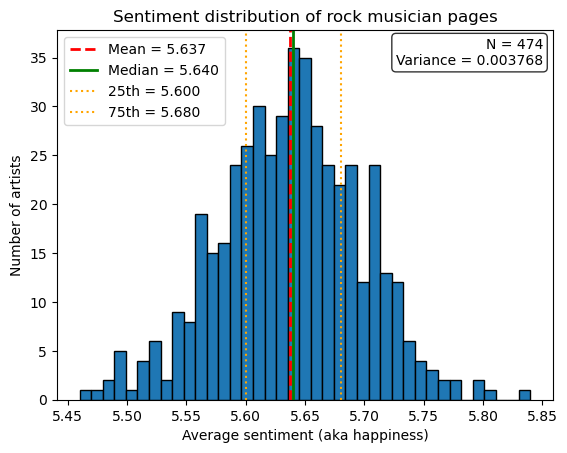

In [260]:
bins = np.linspace(G_sentiment_arr.min(), G_sentiment_arr.max(), 40)

plt.hist(G_sentiment_arr, bins=bins, edgecolor='black')

# Add mean and median, 25th and 75th percentiles as vertical line and variance:
mean_val = np.nanmean(G_sentiment_arr)
median_val = np.nanmedian(G_sentiment_arr)
p25 = np.nanpercentile(G_sentiment_arr, 25)
p75 = np.nanpercentile(G_sentiment_arr, 75)
var_val = np.nanvar(G_sentiment_arr)
n = len(G_sentiment_arr)

# Vertical lines
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_val:.3f}')
plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median = {median_val:.3f}')
plt.axvline(p25, color='orange', linestyle=':', linewidth=1.5, label=f'25th = {p25:.3f}')
plt.axvline(p75, color='orange', linestyle=':', linewidth=1.5, label=f'75th = {p75:.3f}')

# Text box
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
textstr = f'N = {n}\nVariance = {var_val:.6f}'
plt.gca().text(0.98, 0.98, textstr, transform=plt.gca().transAxes,
               fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=props)

plt.title("Sentiment distribution of rock musician pages")
plt.xlabel("Average sentiment (aka happiness)")
plt.ylabel("Number of artists")
plt.legend()
plt.show()

> **Who are the 10 artists with happiest and saddest pages?**\
> **ANSWER:**\
> See the code below again, and the outputs have the answers.

In [259]:
# Top 10 happiest artist:
top_10_happiest = sorted(G_undirected.nodes(data=True), key=lambda x: (x[1]['sentiment'] is not None, x[1]['sentiment']), reverse=True)[:10]
top_10_saddest = sorted(G_undirected.nodes(data=True), key=lambda x: (x[1]['sentiment'] is not None, x[1]['sentiment']))[:10]

print("Top 10 happiest artists:")
for artist, data in top_10_happiest:
    print(f"{artist}: {data['sentiment']}")

print("\nTop 10 saddest artists:")
for artist, data in top_10_saddest:
    print(f"{artist}: {data['sentiment']}")

Top 10 happiest artists:
The_Boxtones: 5.84
Lenny_Kravitz: 5.81
Kenny_Loggins: 5.8
Michael_Martin_Murphey: 5.8
Steve_Winwood: 5.78
Tracy_Chapman: 5.78
Jackson_Browne: 5.77
Chubby_Checker: 5.77
Greta_Van_Fleet: 5.76
Dan_Fogelberg: 5.76

Top 10 saddest artists:
Pantera: 5.46
Megadeth: 5.47
Sex_Pistols: 5.48
Guns_N'_Roses: 5.48
Limp_Bizkit: 5.49
Black_Sabbath: 5.49
Marilyn_Manson: 5.49
W.A.S.P._(band): 5.49
Days_of_the_New: 5.49
Slipknot_(band): 5.5


*Exercise*: Community sentiment distribution. 
  
> * Last week we calculated the stuctural communities of the graph. For this exercise, we use those communities (just the 10 largest ones). Specifically, you should calculate the average the average sentiment of the nodes in each community to find a *community level sentiment*. 
>   - Name each community by its three most connected bands. (Or feed the list of bands in each community and ask the LLM to come up with a good name for the community).
>   - What are the three happiest communities? 
>   - what are the three saddest communities?
>   - Do these results confirm what you can learn about each community by comparing to the genres, checking out the word-clouds for each community, and reading the wiki-pages? 
> * Compare the sentiment of the happiest and saddest communities to the overall (entire network) distribution of sentiment that you calculated in the previous exercise. Are the communities very differenct from the average? Or do you find the sentiment to be quite similar across all of the communities?

<div class="alert alert-block alert-info">
As above, feel free to go nuts with help from an LLM with this exercise for the technical parts. But try to answer the questions about interpreting the results with your own human brain.
</div>

**Note**: Calculating sentiment may take a long time, so arm yourself with patience as your code runs (remember to check that it runs correctly, before waiting patiently). Further, these tips may speed things up. And save somewhere, so you don't have to start over.

**Tips for speed**
* If you use `freqDist` prior to finding the sentiment, you only have to find it for every unique word and hereafter you can do a weighted mean.
* More tips for speeding up loops https://wiki.python.org/moin/PythonSpeed/PerformanceTips#Loops

> **Last week we calculated the stuctural communities of the graph. For this exercise, we use those communities (just the 10 largest ones). Specifically, you should calculate the average the average sentiment of the nodes in each community to find a *community level sentiment*.** 
>   - **Name each community by its three most connected bands. (Or feed the list of bands in each community and ask the LLM to come up with a good name for the community).**


>   - **What are the three happiest communities?**

>   - **What are the three saddest communities?**

>   - **Do these results confirm what you can learn about each community by comparing to the genres, checking out the word-clouds for each community, and reading the wiki-pages?**

> **Compare the sentiment of the happiest and saddest communities to the overall (entire network) distribution of sentiment that you calculated in the previous exercise. Are the communities very differenct from the average? Or do you find the sentiment to be quite similar across all of the communities?**